In [1]:
from typing import Callable
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Hamiltonian for Hydrogen molecule

Reference: https://dojo.qulacs.org/en/latest/notebooks/7.1_quantum_phase_estimation_detailed.html#Example:-Calculation-of-the-ground-state-energy-of-the-hydrogen-molecular-Hamiltonian-using-the-quantum-phase-estimation-algorithm

The Hamiltonian of the Hydrogen molecule is written in the second quantized, expressed in terms of creation and annihilation operators acting on some basis of molecular orbitals. Then, using Bravyi-Kitaev transformation, this Hamiltonian is mapped into qubits using the minimial STO-6G basis, getting the 4-qubit Hamiltonian
$$
H = f_0 I + f_1Z_0 + f_2 Z_1 + f_3Z_2 + f_1Z_0Z_1 \\
+ f_4Z_0Z_2 + f_5Z_1Z_3 + f_6X_0Z_1X_2 + f_6Y_0Z_1Y_2 \\
+ f_7Z_0Z_1Z_2 + f_4Z_0Z_2Z_3 + f_3 Z_1Z_2Z_3 \\
+ f_6 X_0 Z_1 X_2 Z_3 + f_6 Y_0 Z_1 Y_2 Z_3 + f_7Z_0Z_1Z_2Z_3,
$$
where the values $f_i$ depend on the fixed bond length of the molecule. Noticing this Hamiltonian stabilizes qubits 1 and 3 when they start in $|0\rangle$ (as in Hartree-Fock state), we can obtain a reduced two-qubit Hamiltonian:
$$
H = \sum_{i} g_i H_i = g_0I + g_1Z_0 + g_2Z_1 + g_3Z_0Z_1 + g_4Y_0Y_1 + g_5X_0X_1,
$$
where the $g_i$ values are function of the $f_i$ values.

We need to decompose $U=e^{-i\tau H}$ into a quantum circuit, where $\tau$ is a constant such that $[E_{\text{min}}, E_{\text{max}}]$ is shrinked to $[0, 2\pi]$. Since $g_0I$ and $g_3Z_0Z_1$ conmute with the other terms:
$$
e^{-i\tau H} = \exp(-i\tau \sum_{i} g_i H_i) = \exp[-i\tau g_0I]\exp[-i\tau g_3Z_0Z_1]\exp[-i\tau H_{eff}],
$$
$$
H_{eff}:= g_1Z_0 + g_2Z_1+ g_4Y_0Y_1 + g_5X_0X_1.
$$
Use Trotterization:
$$
U_{eff}:=\exp[-i\tau H_{eff}] \approx \left(\prod_{i=1,2,4, 5}\exp[-i\tau H_i/N ]\right)^N.
$$
The exponentials in the right-hand side are of the form $\exp(i\theta P)$, where $P$ is a Pauli matrix, and it is easy to implement it in a quantum circuit.

### Finding eigenvalues of $H$ and $H_{\text{eff}}$ classically

In [2]:
def kron4(a: np.ndarray, b: np.ndarray, c: np.ndarray, d: np.ndarray) -> np.ndarray:
    # Tensor product of four matrices
    return np.kron(np.kron(np.kron(a, b), c), d)

def construct_H_complete(coeff: list[float]) -> np.ndarray:
    # Pauli matrices and the identity matrix
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    I = np.eye(2, dtype=complex)
    
    H = np.zeros((16, 16), dtype=complex)
    
    H += coeff[0] * kron4(I, I, I, I)
    H += coeff[1] * kron4(Z, I, I, I)
    H += coeff[2] * kron4(I, Z, I, I)
    H += coeff[3] * kron4(I, I, Z, I)
    H += coeff[1] * kron4(Z, Z, I, I)
    H += coeff[4] * kron4(Z, I, Z, I)
    H += coeff[5] * kron4(I, Z, I, Z)
    H += coeff[6] * kron4(X, Z, X, I)
    H += coeff[6] * kron4(Y, Z, Y, I)
    H += coeff[7] * kron4(Z, Z, Z, I)
    H += coeff[4] * kron4(Z, I, Z, Z)
    H += coeff[3] * kron4(I, Z, Z, Z)
    H += coeff[6] * kron4(X, Z, X, Z)
    H += coeff[6] * kron4(Y, Z, Y, Z)
    H += coeff[7] * kron4(Z, Z, Z, Z)
    
    return H

In [3]:
def construct_H_eff(coeff: list[float]) -> np.ndarray:
    c1, c2, c3, c4 = coeff

    # Pauli matrices and the identity matrix
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    I = np.eye(2, dtype=complex)

    # c1 * Z_0
    term1 = c1 * np.kron(Z, I)

    # c2 * Z_1 
    term2 = c2 * np.kron(I, Z)

    # c3 * Y_0 Y_1
    term3 = c3 * np.kron(Y, Y)

    # c4 * X_0 X_1
    term4 = c4 * np.kron(X, X)

    return term1 + term2 + term3 + term4



def construct_hamiltonian(coeff: list[float]) -> np.ndarray:
    g0, g1, g2, g3, g4, g5 = coeff
    
    # Pauli matrix Z
    Z = np.array([[1, 0], [0, -1]], dtype=complex)

    # g0 * I
    term1 = g0 * np.eye(4, dtype=complex)
    
    # g3 * Z_0 Z_1
    term2 = g3 * np.kron(Z, Z)
    
    # H_eff
    H_eff = construct_H_eff([g1, g2, g4, g5])

    return term1 + term2 + H_eff

In [5]:
coeffs_df = pd.read_csv("table_coeffs.csv")
coeffs_df.head()

,nuclear_dist,I,Z0,Z1,Z0Z1,X0X1,Y0Y1,t0,ordering,trotter_error
0,0.20,2.8489,0.5678,−1.4508,0.6799,0.0791,0.0791,1.50,𝑍0·𝑋0⁢𝑋1·𝑍1·𝑌0⁢𝑌1,0.0124
1,0.25,2.1868,0.5449,−1.2870,0.6719,0.0798,0.0798,1.59,𝑍0·𝑌0⁢𝑌1·𝑍1·𝑋0⁢𝑋1,0.0521
2,0.30,1.7252,0.5215,−1.1458,0.6631,0.0806,0.0806,1.77,𝑋0⁢𝑋1·𝑍0·𝑌0⁢𝑌1·𝑍1,0.0111
3,0.35,1.3827,0.4982,−1.0226,0.6537,0.0815,0.0815,2.08,𝑍0·𝑋0⁢𝑋1·𝑍1·𝑌0⁢𝑌1,0.0368
4,0.40,−0.2047,0.4754,−0.9145,0.6438,0.0825,0.0825,2.10,𝑍0·𝑋0⁢𝑋1·𝑍1·𝑌0⁢𝑌1,0.0088


In [16]:
H_eff = construct_H_eff([0.3593, -0.4826, 0.0896, 0.0896])
H = construct_hamiltonian([-0.4584, 0.3593, -0.4826, 0.5818, 0.0896, 0.0896])

In [17]:
print("Eigenvalores de H:", np.linalg.eigvals(H))
print("Eigenvalores de H_eff:", np.linalg.eigvals(H_eff))

Eigenvalores de H: [-1.90096027e+00+0.j -1.79439726e-01+0.j  1.00000000e-04+0.j
  2.46700000e-01+0.j]
Eigenvalores de H_eff: [-0.86076027+0.j  0.86076027+0.j -0.1233    +0.j  0.1233    +0.j]


Verification that the minimum eigenvalue of the 4-qubit Hamiltonian is the same as the 2-qubit Hamiltonian:

In [31]:
coeff_fs = [
    -0.81261, 0.171201, 0.16862325, -0.2227965, 0.171201,
    0.12054625, 0.17434925, 0.04532175, 0.04532175, 
    0.165868, 0.12054625, -0.2227965, 
    0.04532175, 0.04532175, 0.165868
    ]
coeff_gs = np.zeros(6)

coeff_gs[0] = coeff_fs[0] + coeff_fs[2] + coeff_fs[5]
coeff_gs[1] = 2*coeff_fs[1] + coeff_fs[4]
coeff_gs[2] = 2*coeff_fs[3]
coeff_gs[3] = 2*(coeff_fs[4] + coeff_fs[7])
coeff_gs[4] = 2*coeff_fs[6]
coeff_gs[5] = 2*coeff_fs[6]
coeff_gs

array([-0.5234405,  0.513603 , -0.445593 ,  0.4330455,  0.3486985,
        0.3486985])

In [27]:
coeff_fs = np.random.rand(8)
coeff_gs = np.zeros(6)

coeff_gs[0] = coeff_fs[0] + coeff_fs[2] + coeff_fs[5]
coeff_gs[1] = 2*coeff_fs[1] + coeff_fs[4]
coeff_gs[2] = 2*coeff_fs[3]
coeff_gs[3] = 2*(coeff_fs[4] + coeff_fs[7])
coeff_gs[4] = 2*coeff_fs[6]
coeff_gs[5] = 2*coeff_fs[6]

In [32]:
H_complete = construct_H_complete(coeff_fs)
H_reduced = construct_hamiltonian(coeff_gs)

In [33]:
eigvals_H_reduced = np.linalg.eigvals(H_reduced)
eigvals_H_complete = np.linalg.eigvals(H_complete)

print("Eigenvalues of 2-qubit Hamiltonian:", eigvals_H_reduced)
print("Eigenvalues of 4-qubit Hamiltonian:", eigvals_H_complete)

Eigenvalues of 2-qubit Hamiltonian: [-2.14241161+0.j  0.22943961+0.j -0.022385  +0.j -0.158405  +0.j]
Eigenvalues of 4-qubit Hamiltonian: [-0.656141  -2.46519033e-32j -2.050935  +6.16297582e-33j
  0.09579661+0.00000000e+00j -2.00876861+0.00000000e+00j
 -0.193586  +0.00000000e+00j -0.422131  +0.00000000e+00j
 -0.422131  +0.00000000e+00j -0.850021  +0.00000000e+00j
 -1.30628   +0.00000000e+00j -0.415094  +0.00000000e+00j
 -1.106935  +0.00000000e+00j  0.012796  +0.00000000e+00j
 -1.106935  +0.00000000e+00j -1.30628   +0.00000000e+00j
 -0.850021  +0.00000000e+00j -0.415094  +0.00000000e+00j]


In [34]:
min(eigvals_H_reduced), min(eigvals_H_complete)

(np.complex128(-2.1424116056030673+0j),
 np.complex128(-2.050935+6.162975822039155e-33j))

### Finding eigenvalues of $H$ and $H_{\text{eff}}$ with Quantum Phase Estimation algorithm

### Initial state with sufficient overlap with the ground state

It turns out that the Hartree-Fock state is $|01\rangle$.

GPU: https://pennylane.ai/install#high-performance-computing-and-gpus

In [5]:
num_shots = None
dev = qml.device("default.qubit", shots = num_shots) # no shots means analytical calculation
#dev = qml.device("lightning.gpu", wires=num_qubits)

In [34]:
@qml.qnode(dev)
def circuit_qpe(
    estimation_wires: list[int],
    q_register: list[int],
    state_prep: Callable[[list[int]], None],
    controlled_unitary: Callable[..., None],
    **kargs
):
    # initial state
    state_prep(q_register)

    for wire in estimation_wires:
        qml.Hadamard(wires=wire)

    for i, control in enumerate(reversed(estimation_wires)):
        controlled_unitary(control, q_register, 2**i, **kargs)

    qml.adjoint(qml.QFT)(wires=estimation_wires)

    return qml.probs(wires=estimation_wires)

In [ ]:
def binary_string_to_decimal(binary_string: str) -> float:
    # binary_string represent the bits of the decimal number in format 0.i_1i_2...i_n
    # where binary_string is i_1i_2...i_n
    res = 0
    for i, bit in enumerate(binary_string):
        res += float(bit)*2**(-i-1)
        
    return res

In [ ]:
tau = 0.640
coeff = [-0.4584, 0.3593, -0.4826, 0.5818, 0.0896, 0.0896]

In [80]:
eigs1 = []
eigs2 = []

#trotter_steps = 5
num_digits = 11

for trotter_steps in range(1, 25):
    results = circuit_qpe(
        estimation_wires=range(num_digits),
        q_register = [num_digits, num_digits+1],
        state_prep = lambda wires: qml.X(wires[0]),
        controlled_unitary = controlledHydrogenUnitary,
        tau = tau,
        trotter_steps = trotter_steps,
        coeff = coeff,
    )
    
    results_ordered = [(f"0.{x:0{num_digits}b}", results[x]) for x in range(len(results))]
    results_ordered.sort(key=lambda tup: tup[1], reverse=True)
    
    phase_1 = binary_string_to_decimal(results_ordered[0][0][2:])
    phase_2 = binary_string_to_decimal(results_ordered[1][0][2:])
    
    result_1 = -2*np.pi*phase_1/tau
    result_2 = -2*np.pi*phase_2/tau
        
    print("Trotter steps:", trotter_steps)
    print(f"1 result ({results_ordered[0][0]}): {result_1:.4f} ", f"- probability: {results_ordered[0][1]:.4f} - phase: {phase_1:.4f}")
    print(f"2 result ({results_ordered[1][0]}): {result_2:.4f}", f"- probability: {results_ordered[1][1]:.4f} - phase: {phase_1:.4f}")
    print("\n")
    
    eigs1.append(result_1)
    eigs2.append(result_2)

Trotter steps: 1
1 result (0.00010010001): -0.6951  - probability: 0.0709 - phase: 0.0708
2 result (0.00010010000): -0.6903 - probability: 0.0516 - phase: 0.0708


Trotter steps: 2
1 result (0.00010100110): -0.7958  - probability: 0.1447 - phase: 0.0811
2 result (0.00010100010): -0.7766 - probability: 0.1165 - phase: 0.0811


Trotter steps: 3
1 result (0.00010101101): -0.8293  - probability: 0.0564 - phase: 0.0845
2 result (0.00010101100): -0.8245 - probability: 0.0558 - phase: 0.0845


Trotter steps: 4
1 result (0.00010101010): -0.8149  - probability: 0.3367 - phase: 0.0830
2 result (0.00010100110): -0.7958 - probability: 0.1557 - phase: 0.0830


Trotter steps: 5
1 result (0.00011000000): -0.9204  - probability: 0.2059 - phase: 0.0938
2 result (0.00010100000): -0.7670 - probability: 0.1398 - phase: 0.0938


Trotter steps: 6
1 result (0.00010100110): -0.7958  - probability: 0.1570 - phase: 0.0811
2 result (0.00010110110): -0.8725 - probability: 0.1115 - phase: 0.0811


Trotter steps: 7

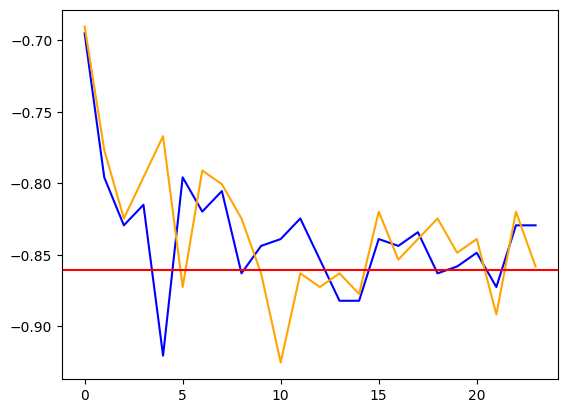

In [85]:
exact_eig = -0.8607602744
plt.plot(eigs1, color="blue")
plt.plot(eigs2, color="orange")
plt.axhline(y=exact_eig, color='r', linestyle='-')

In [109]:
results = circuit_qpe(
    estimation_wires=range(11),
    q_register = [11, 12],
    state_prep = lambda wires: qml.X(wires[1]),
    controlled_unitary = controlledHydrogenUnitary,
    tau = tau,
    trotter_steps = trotter_steps,
    coeff = coeff,
)

In [56]:
num_digits = 6

results = circuit_qpe(
    estimation_wires=range(num_digits),
    q_register = [num_digits],
    state_prep = lambda wires: qml.X(wires[0]),
    controlled_unitary = lambda control, q_register, k: qml.ControlledPhaseShift(2*k * np.pi / 5, wires=[control]+q_register)
)

results_ordered = [(f"0.{x:0{num_digits}b}", results[x]) for x in range(len(results))]
results_ordered.sort(key=lambda tup: tup[1], reverse=True)

print(results_ordered[0])
print(binary_string_to_decimal(results_ordered[0][0][2:]))

('0.001101', np.float64(0.8751683167958477))
0.203125


In [112]:
cumsum = np.cumsum([tup[1] for tup in results_ordered])
for i, s in enumerate(cumsum):
    if s >= 0.9:
        cumsum_i = i
        print(i)
        break

93


In [113]:
results_ordered = results_ordered[:cumsum_i + 1]
results_ordered.sort(key=lambda tup: tup[0])

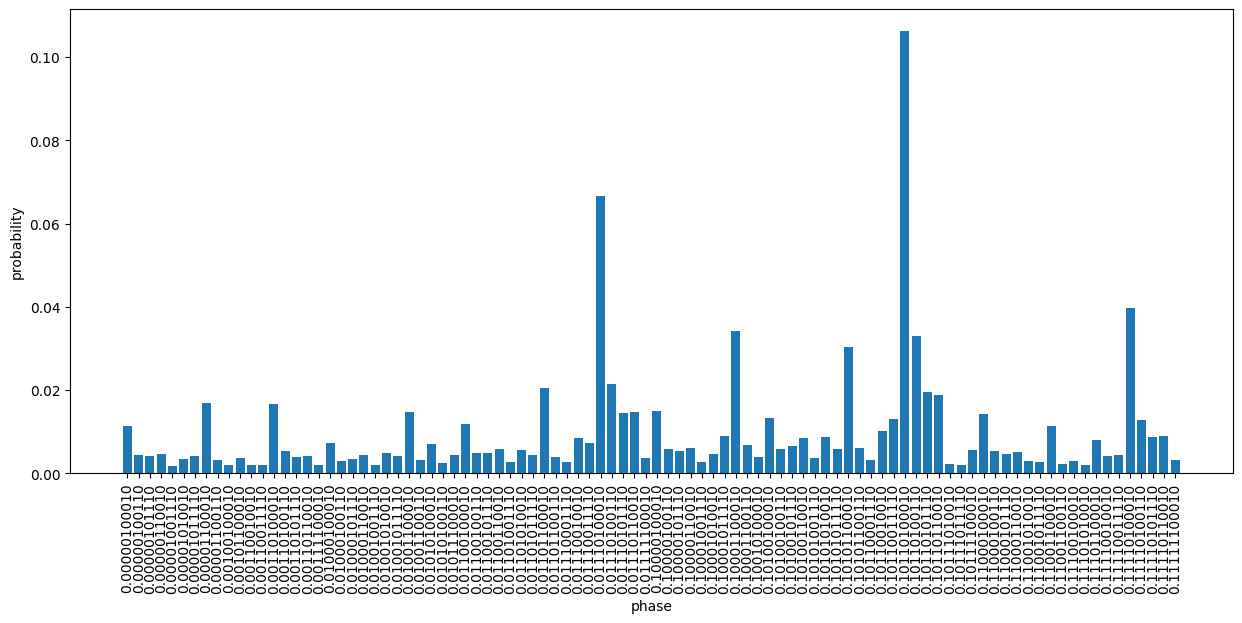

In [114]:
plt.figure(figsize=(15, 8))
plt.bar([tup[0] for tup in results_ordered], [tup[1] for tup in results_ordered])
plt.xlabel("phase")
plt.ylabel("probability")
plt.xticks(rotation="vertical")
plt.subplots_adjust(bottom=0.3)

In [115]:
max_i = np.argmax([tup[1] for tup in results_ordered])
max_i

np.int64(69)

In [116]:
results_ordered[max_i]

('0.10110100010', np.float64(0.10619373096465003))

In [117]:
res = 0
for i, bit in enumerate(results_ordered[max_i][0][2:]):
    res += float(bit)*2**(-i-1)
    
print(res)

0.7041015625


In [118]:
- res/tau

-1.10015869140625